Ejemplo --- Análisis de sentimientos de IMDB usando TF.2.0
===

* *30 min* | Última modificación: Abril 5, 2020

Basado en https://www.tensorflow.org/tutorials/keras/text_classification_with_hub

En este tutorial se utiliza minería de texto para clasificar una reseña de una película como *positiva* o *negativa*.

## Importación de librerías

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

print(tf.__version__)
print(hub.__version__)

2.1.0
0.8.0


## Carga de datos

In [2]:
train_data, validation_data, test_data = tfds.load(
    name="imdb_reviews",
    split=("train[:60%]", "train[60%:]", "test"),
    as_supervised=True,
)

## Exploración de datos

In [3]:
#
# Se mostran los primeros 5 datos del dataframe
#
train_examples_batch, train_labels_batch = next(iter(train_data.batch(5)))

for txt, rev in zip(train_examples_batch, train_labels_batch):
    print(txt)
    print()
    print('Review:', rev)
    print('------')

tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)

Review: tf.Tensor(0, shape=(), dtype=int64)
------
tf.Tensor(b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a l

## Representación del texto como un embedding

In [4]:
# 
#  En este modelo se usa un modelo pre-entrenado de embedding llamado
#  google/tf2-preview/gnews-swivel-20dim/1
# 
#  https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1
#
embedding_url = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"

#
#  La capa inicial de la red neuronal es el modelo de embedding para 
#  transfomar el texto en un vector numérico
#
hub_layer = hub.KerasLayer(embedding_url, input_shape=[], dtype=tf.string, trainable=True)

#
# Aplicación del embedding a los primeros tres ejemplos del dataset
# 
hub_layer(train_examples_batch[:3])

<tf.Tensor: shape=(3, 20), dtype=float32, numpy=
array([[ 1.765786  , -3.882232  ,  3.9134233 , -1.5557289 , -3.3362343 ,
        -1.7357955 , -1.9954445 ,  1.2989551 ,  5.081598  , -1.1041286 ,
        -2.0503852 , -0.72675157, -0.65675956,  0.24436149, -3.7208383 ,
         2.0954835 ,  2.2969332 , -2.0689783 , -2.9489717 , -1.1315987 ],
       [ 1.8804485 , -2.5852382 ,  3.4066997 ,  1.0982676 , -4.056685  ,
        -4.891284  , -2.785554  ,  1.3874227 ,  3.8476458 , -0.9256538 ,
        -1.896706  ,  1.2113281 ,  0.11474707,  0.76209456, -4.8791065 ,
         2.906149  ,  4.7087674 , -2.3652055 , -3.5015898 , -1.6390051 ],
       [ 0.71152234, -0.6353217 ,  1.7385626 , -1.1168286 , -0.5451594 ,
        -1.1808156 ,  0.09504455,  1.4653089 ,  0.66059524,  0.79308075,
        -2.2268345 ,  0.07446612, -1.4075904 , -0.70645386, -1.907037  ,
         1.4419787 ,  1.9551861 , -0.42660055, -2.8022065 ,  0.43727064]],
      dtype=float32)>

## Creación del modelo como una secuencia de capas

In [5]:
#
#  Note que se adicionan las capas una a una.
#
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation="relu"))
model.add(tf.keras.layers.Dense(1))

#
#  Las capas también podrían haberse adicionado como una lista:
#
#  model = keras.Sequential(
#     [
#         hub_layer
#         tf.keras.layers.Dense(16, activation="relu")
#         tf.keras.layers.Dense(1)
#     ]
#  )
#

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 20)                400020    
_________________________________________________________________
dense (Dense)                (None, 16)                336       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 400,373
Trainable params: 400,373
Non-trainable params: 0
_________________________________________________________________


## Compilación del modelo

In [6]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

## Entrenamiento

In [7]:
#
#  history almacena la información relacionada con el entrenamiento
#
history = model.fit(
    train_data.shuffle(10000).batch(512),
    epochs=20,
    validation_data=validation_data.batch(512),
    verbose=1,
)

Epoch 1/20
30/30 [==============================] - 9s 292ms/step - loss: 1.2951 - accuracy: 0.4293 - val_loss: 0.9647 - val_accuracy: 0.4578
Epoch 2/20
30/30 [==============================] - 9s 301ms/step - loss: 0.8185 - accuracy: 0.5034 - val_loss: 0.6914 - val_accuracy: 0.5735
Epoch 3/20
30/30 [==============================] - 8s 272ms/step - loss: 0.6481 - accuracy: 0.6071 - val_loss: 0.6137 - val_accuracy: 0.6341
Epoch 4/20
30/30 [==============================] - 8s 277ms/step - loss: 0.5821 - accuracy: 0.6673 - val_loss: 0.5665 - val_accuracy: 0.6691
Epoch 5/20
30/30 [==============================] - 9s 302ms/step - loss: 0.5367 - accuracy: 0.7105 - val_loss: 0.5297 - val_accuracy: 0.6978
Epoch 6/20
30/30 [==============================] - 9s 284ms/step - loss: 0.4982 - accuracy: 0.7413 - val_loss: 0.4973 - val_accuracy: 0.7367
Epoch 7/20
30/30 [==============================] - 8s 283ms/step - loss: 0.4652 - accuracy: 0.7685 - val_loss: 0.4695 - val_accuracy: 0.7679
Epoch 

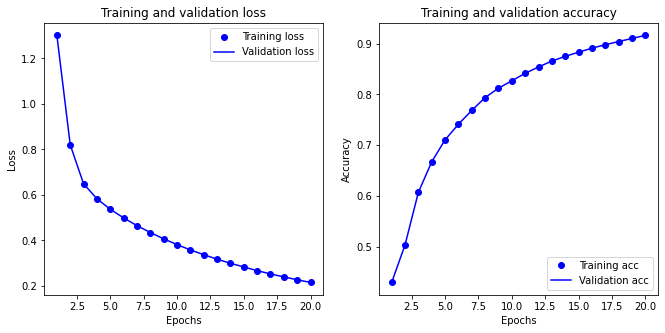

In [8]:
def plot_history(history):
    
    plt.figure(figsize=(11, 5))
    
    history_dict = history.history

    acc = history_dict['accuracy']
    val_acc = history_dict['accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['loss']

    #
    # loss
    #
    plt.subplot(1, 2, 1)
    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    #
    # accuracy
    #
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    
plot_history(history)

## Evaluación

In [9]:
results = model.evaluate(test_data.batch(512), verbose=1)

for name, value in zip(model.metrics_names, results):
    print("%s: %.3f" % (name, value))

     49/Unknown - 10s 205ms/step - loss: 0.3369 - accuracy: 0.8387loss: 0.337
accuracy: 0.839


**Ejercicio.---** Cambie la capa de embedding por:

* google/tf2-preview/gnews-swivel-20dim-with-oov/1

* google/tf2-preview/nnlm-en-dim50/1

* google/tf2-preview/nnlm-en-dim128/1

y compare los resultados

**Ejercicio.---** ¿Cómo varía la precisión del modelo con la cantidad de neuronas de la capa oculta?